<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

In [2]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [4]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [5]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [8]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [9]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [11]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [12]:
CORPUS_PATH = './data/MSDS453_Sec57_TestQA_ClassCorpus.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [13]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193"
Doc_ID,191,192,193
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...


## Tokenize Words

In [14]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
191    [state, nation, bring, cold, war, let, dump, b...
192    [odd, octopussy, suppose, like, pretty, memora...
193    [james, bond, film, year, bad, barometer, popu...
194    [introduction, new, james, bond, bring, skepti...
195    [box, office, remain, strong, worldwide, arden...
Name: lemmas, dtype: object

In [15]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193"
Doc_ID,191,192,193
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, octopussy, suppose, like, pretty, memora...","[james, bond, film, year, bad, barometer, popu..."


## Reassemble Leminized Words

In [16]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [17]:
corpus_df['lemmas_joined'].head()

Doc_ID
191    state nation bring cold war let dump bond rubb...
192    odd octopussy suppose like pretty memorably fo...
193    james bond film year bad barometer popular moo...
194    introduction new james bond bring skepticism m...
195    box office remain strong worldwide ardent fan ...
Name: lemmas_joined, dtype: object

In [18]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193"
Doc_ID,191,192,193
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, octopussy, suppose, like, pretty, memora...","[james, bond, film, year, bad, barometer, popu..."


## Vocabulary Data Wrangling

In [19]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 12449
Curated Vocabulary size: 3013


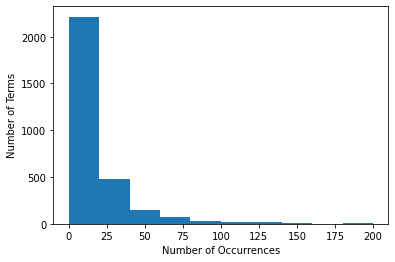

In [20]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [21]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
191    [state, nation, bring, cold, war, let, dump, b...
192    [odd, suppose, pretty, forget, memory, process...
193    [james, bond, year, bad, popular, mood, layer,...
194    [introduction, new, james, bond, bring, major,...
195    [box, office, remain, strong, fan, james, bond...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words 

In [22]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [23]:
corpus_df.head().T

Doc_ID,191,192,193,194,195
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale,JLU_Doc4_JamesBondCasinoRoyale,JLU_Doc5_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU,JLU,JLU
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...,The introduction of a new James Bond always br...,Although box office has remained strong worldw...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193","Action_James Bond, Casino Royale_N_194","Action_James Bond, Casino Royale_N_195"
Doc_ID,191,192,193,194,195
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...,[The introduction of a new James Bond always b...,[Although box office has remained strong world...
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, suppose, pretty, forget, memory, process...","[james, bond, year, bad, popular, mood, layer,...","[introduction, new, james, bond, bring, major,...","[box, office, remain, strong, fan, james, bond..."


## Review Documents By Movie Title

In [24]:
print(corpus_df['Movie Title'].unique())

['James Bond, Casino Royale' 'Mission Impossible Fallout'
 'Pirates of the Caribbean: The Curse of the Black Pearl' 'Speed Racer'
 'Cruella' 'Encanto' 'Frozen II' 'Red Notice' 'Spider Man 3'
 'The Grand Budapest Hotel' 'Hereditary' 'Lamb' 'The Conjuring 3'
 'The Ring' 'Us' 'Arrival' 'Guardians of the Galaxy' 'Interstellar'
 'The Martian' 'The Matrix Resurrections']


In [25]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Red Notice'].copy()
movie_df.head(3).T

Doc_ID,151,152,153
DSI_Title,DYZ_Doc1_RedNotice,DYZ_Doc2_RedNotice,DYZ_Doc3_RedNotice
Student Name,DYZ,DYZ,DYZ
Genre of Movie,Comedy,Comedy,Comedy
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Red Notice,Red Notice,Red Notice
Text,There’s a stinging form of déjà vu that can sw...,Three of the biggest movie stars in the world ...,"For decades, the easiest way to determine whet..."
Descriptor,Comedy_Red Notice_N_151,Comedy_Red Notice_N_152,Comedy_Red Notice_N_153
Doc_ID,151,152,153
raw_sentences,[There’s a stinging form of déjà vu that can s...,[Three of the biggest movie stars in the world...,"[For decades, the easiest way to determine whe..."
lemmas,"[form, sweep, watch, feel, red, notice, moment...","[big, star, world, big, action, adventure, spe...","[decade, easy, way, determine, blockbuster, su..."


## Knowledge Graph Extraction

In [26]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'Your brain might notice some familiar fight staging, a half-remembered plot point, or the whistling of the Indiana Jones theme.'

In [27]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 398/398 [00:04<00:00, 82.04it/s]


In [28]:
entity_pairs

[['you', 'it'],
 ['such  skin', 'such  end'],
 ['', 'movies'],
 ['famous  headliners', 'horrid  mediocrity'],
 ['Red Notice', 'frenzied  action'],
 ['brain', 'remembered Indiana Jones theme'],
 ['so  you', 'overeager Leonard DiCaprio meme'],
 ['before nonsense he', 'before nonsense that'],
 ['Why  you', 'hairnet'],
 ['You', ''],
 ['thieving femme who', 'Fast  Gisele'],
 ['I', 'also browser history'],
 ['when  joke', ''],
 ['Then  you', ''],
 ['', ''],
 ['', 'movies'],
 ['he', 'Booth'],
 ['pair', 'out jungle her'],
 ['path', 'twists'],
 ['so  all', 'it'],
 ['whole  I', 'cross  reveal'],
 ['', ''],
 ['it', 'damn  puzzle'],
 ['maniacal exposition that', 'best Bond villains'],
 ['razzle dazzle', ''],
 ['above  promise', 'sultry tango Johnson'],
 ['all', 'above'],
 ['dance scene', 'good  cop'],
 ['However  Johnson', 'entire movie star nails'],
 ['snarly  it', 'snarly  smolder'],
 ['so  arc', 'them'],
 ['', 'Also landing punchlines'],
 ['she', 'winsomely Wonder babies'],
 ['she', 'step'],
 [

### Create DataFrame (Source, Target, Edge)

In [29]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [30]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [31]:
kg_df.head(6).T

,0,1,3,4,5,6
source,you,such skin,famous headliners,red notice,brain,so you
target,it,such end,horrid mediocrity,frenzied action,remembered indiana jones theme,overeager leonard dicaprio meme
edge,’s,is,rescue,is less,notice,come from


In [32]:
len(corpus_text_sentences)

398

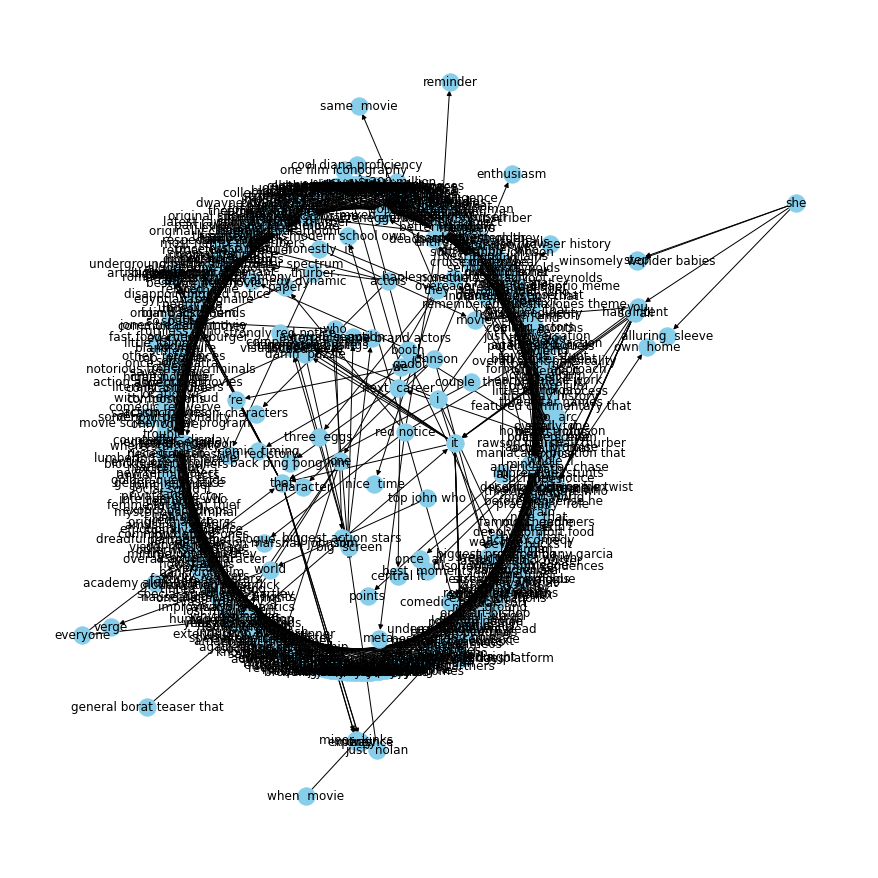

In [33]:
plot_graph(kg_df, use_circular=False)

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [34]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale,JLU_Doc4_JamesBondCasinoRoyale,JLU_Doc5_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU,JLU,JLU
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...,The introduction of a new James Bond always br...,Although box office has remained strong worldw...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193","Action_James Bond, Casino Royale_N_194","Action_James Bond, Casino Royale_N_195"
Doc_ID,191,192,193,194,195
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...,[The introduction of a new James Bond always b...,[Although box office has remained strong world...
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, suppose, pretty, forget, memory, process...","[james, bond, year, bad, popular, mood, layer,...","[introduction, new, james, bond, bring, major,...","[box, office, remain, strong, fan, james, bond..."


In [35]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet 

In [36]:
data = datafull[['Text','Genre of Movie']].copy()

In [37]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [38]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Comedy          1                      60
Horror          2                      50
Sci-Fi          3                      50
Action          0                      40
dtype: int64

## Create Datasets for Model Development

In [39]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [40]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [41]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [42]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [44]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [45]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [46]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '’', 'the', 'film', 's', 'i', 'movie', 'one', 'it',
       'like', '“', '”', 'time', 'character', 'bond', 'but', 'story',
       'also', 'make'], dtype='<U18')

In [47]:
vocab[-20:]

array(['vastness', 'vanished', 'vampire', 'valley', 'vain', 'vacationing',
       'utilizes', 'utilized', 'utilize', 'ursula', 'urging', 'urban',
       'uptight', 'upstaging', 'upsetting', 'upright', 'upping', 'upper',
       'upbeat', 'up'], dtype='<U18')

## Example of Encoded Words

In [48]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([ 450,  244,    1,  794, 3023, 1918,  475,  475])

In [49]:
len(encoder.get_vocabulary())

5000

In [50]:
encoder(data['Text'][0])

<tf.Tensor: shape=(372,), dtype=int64, numpy=
array([ 931,  931, 1384,  718,  327,   33,  779,  463,  286,    5,    1,
         15,    1,    1,  701,    5,   42, 4164, 1515,    5,    1,  936,
         15,    1,    1,    1,    1,    1,   35,   74,   15, 3344,    5,
        342, 1165, 1857,  315, 1791, 1086,  733,  515,  357,  338,  100,
          4, 2632,    1,  357,    1,  593, 2384,   10, 3483, 3939,    1,
       2671,  935,  174,    5,   15,    1, 2821,   74,  343,  116, 4212,
        199,  824, 2866,   79,    1, 1623,   15,   14,  276,  913, 1165,
       1500,  281, 4162,   27,    1,    1, 1985,  408,  223,    8, 4194,
         68,    4,   10,  307,  154,   36, 3549, 1263,  349,   52, 1003,
       3602,   15, 3081,  905,   72,  130,  606,  226,    1, 1208,  903,
        576,  780, 3551,  174,   10, 3551,    1, 4971, 2078, 4888,  105,
       1070,    1, 1547,    3,  515,   15,   20,  249, 1065,   36, 3553,
       4734, 4333,  189,    1,  255,   96,  609,   64, 1224, 4051,    6,
     

In [51]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'With \xe2\x80\x9c Frozen II , \xe2\x80\x9d Disney done impossible : It \xe2\x80\x99 made terrific animated-musical sequel . Over past 25 year , studio released heap direct-to-video follow-up biggest hit , \xe2\x80\x9c Return Jafar \xe2\x80\x9d \xe2\x80\x9c The Lion King 1\xc2\xbd . \xe2\x80\x9d All forgettable best , forever banished darkest corner Disney+ . But curse lifted . The second \xe2\x80\x9c Frozen \xe2\x80\x9d even better first , dazzling animation mature tuneful score . Call \xe2\x80\x9c The Icicle Strikes Back . \xe2\x80\x9d Elsa sang , \xe2\x80\x9c I \xe2\x80\x99 never going back ! The past past ! \xe2\x80\x9d And \xe2\x80\x9c Frozen II \xe2\x80\x9d wisely followed path . Instead rehashing 2013 film , piling complication involving queen \xe2\x80\x99 magical ability freeze fingertip , start fresh new , out-of-the-icebox adventure . Our heroine sits throne Arendelle , despite high queen , Elsa ( Idina Menzel ) feel nagging void . She begin hearing siren song calli

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [52]:
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [53]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [54]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 77s 1s/step - loss: 1.3830 - accuracy: 0.3019 - val_loss: 1.3432 - val_accuracy: 0.3333
Epoch 2/200
53/53 [==============================] - 56s 1s/step - loss: 1.0934 - accuracy: 0.4528 - val_loss: 1.0576 - val_accuracy: 0.4444
Epoch 3/200
53/53 [==============================] - 56s 1s/step - loss: 0.7310 - accuracy: 0.7484 - val_loss: 1.0631 - val_accuracy: 0.5556
Epoch 4/200
53/53 [==============================] - 57s 1s/step - loss: 0.2672 - accuracy: 0.9497 - val_loss: 0.3536 - val_accuracy: 0.8889
Epoch 5/200
53/53 [==============================] - 56s 1s/step - loss: 0.1383 - accuracy: 0.9623 - val_loss: 0.7167 - val_accuracy: 0.8889
Epoch 6/200
53/53 [==============================] - 56s 1s/step - loss: 0.0601 - accuracy: 0.9811 - val_loss: 0.4046 - val_accuracy: 0.7778
CPU times: user 21min 4s, sys: 29.7 s, total: 21min 34s
Wall time: 6min 24s


## Model Performance Test Accuracy

In [55]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 170ms/step - loss: 1.0361 - accuracy: 0.6111
Test Loss: 1.036132574081421
Test Accuracy: 0.6111111044883728


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,1.093,0.453,1.058,0.444
2,0.731,0.748,1.063,0.556
3,0.267,0.950,0.354,0.889
4,0.138,0.962,0.717,0.889
5,0.060,0.981,0.405,0.778


In [58]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

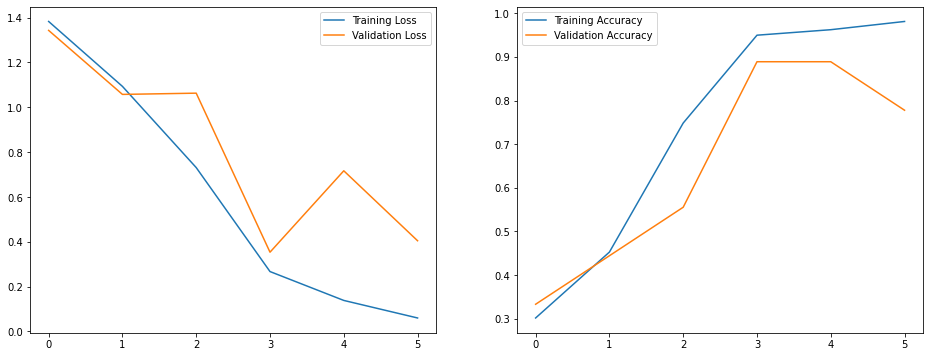

In [59]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [60]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

In [61]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

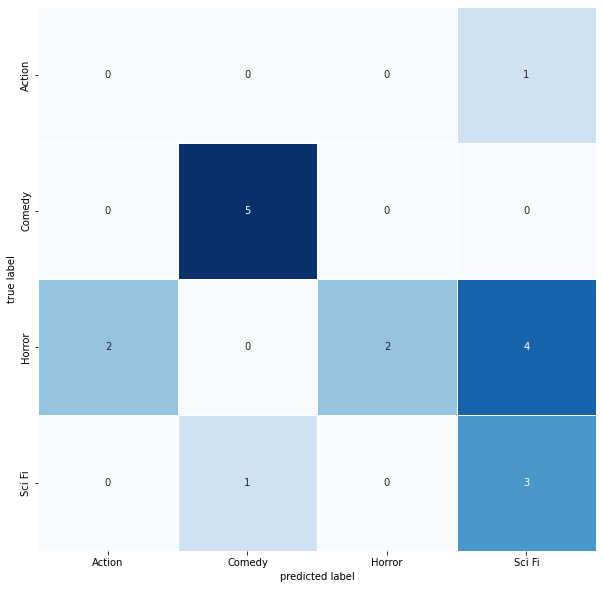

In [62]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [63]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [64]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.07%,0.16%,1.07%,75.08%,1.44%,89.26%,0.60%,0.25%,3.93%,0.66%,11.48%,0.21%,0.10%,0.06%,0.07%
Comedy,99.47%,2.53%,13.46%,14.91%,52.19%,3.16%,92.46%,1.33%,0.40%,81.16%,1.65%,1.33%,95.14%,0.54%,97.74%
Horror,0.00%,0.97%,2.17%,4.36%,0.70%,5.03%,0.09%,3.06%,92.72%,0.13%,79.11%,2.22%,0.01%,1.17%,0.01%
Sci Fi,0.46%,96.34%,83.30%,5.65%,45.67%,2.54%,6.86%,95.35%,2.95%,18.05%,7.76%,96.24%,4.75%,98.23%,2.19%


## RNN Model Architecture

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        